Imports

In [3]:
import gym
import numpy as np

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (16, 10)

from tqdm.auto import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import Adam
from torch.distributions import Categorical
from torch.utils.data import TensorDataset, DataLoader

Our functions

In [4]:
from Train_policy_func import Policy, load_policy, evaluate_all_policies
from Generate_traj_func import generate_trajectory
from Plot_Functions import plot_suboptimality, plot_trajectory_performance, plot_Scores, plot_suboptimality_three_policies, plot_scores_RLHF
from OPPO import baseline_Acrobot_v0, OPPO_update_Acrobot, set_seed
from PPO import evaluate_policy
from pairs_generator import sample_preference_pairs
from DPO import DPO_training



beta by default 0.5


Creating policies and changing seeds:

In [5]:
class ShapedAcrobot(gym.Wrapper):
    def __init__(self, env, alpha=1.0, gamma=0.99):
        super().__init__(env)
        self.alpha, self.gamma = alpha, gamma
        self.last_pot = None

    def _potential(self, obs):
        c1, s1, c2, s2, a1, a2 = obs
        c12 = c1*c2 - s1*s2
        # normalized tip height in [–1,1]:
        return -(c1 + c12) / 2.0

    def reset(self, **kwargs):
        obs = self.env.reset(**kwargs)
        self.last_pot = self._potential(obs)
        return obs

    def step(self, action):
        obs, reward, done, info = self.env.step(action)
        # compute shaping term:
        pot = self._potential(obs)
        shaping = self.gamma * pot - self.last_pot
        shaped_reward = reward + self.alpha * shaping  #  -β*(θ̇1**2 + θ̇2**2)
        self.last_pot = pot
        return obs, shaped_reward, done, info




In [6]:
env_name='Acrobot-v1-perso'
env = ShapedAcrobot(gym.make("Acrobot-v1"), alpha=1.0, gamma=0.99)
obs_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

baseline = baseline_Acrobot_v0
target_score = -150 # for CartPole-v0

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ── Hyperparams for OPPO ──
lr_oppo                 = 0.003
n_episodes              = 3000 # keep same “number of iterations” for fair comparison
max_t                   = 500  # cap on steps per episode
print_every             = 50   # print every x episodes and avg also the score for every x episodes
gamma                   = 0.99



load_policies   = True
evaluate_pi_ref = False
plot_scores     = False
n_eval          = 100

Policy_list     = []
seeds_list      = [35,42,100]
# seeds_list      = [35]

for seed in seeds_list:
    set_seed(seed, env)

    if load_policies:
        print(fr"Loading pi_1 and pi_2 with {seed=}")
        pi_1 = load_policy(f"./Policies/pi1_ref_{env_name}_seed_{seed}.pth", obs_dim, action_dim, device)
        pi_2 = load_policy(f"./Policies/pi2_ref_{env_name}_seed_{seed}.pth", obs_dim, action_dim, device)

    else:
        print(f"Training pi_1 and pi_2 with seed {seed}")

        pi_1 = Policy(state_size=obs_dim, action_size=action_dim).to(device)
        opt1 = torch.optim.Adam(pi_1.parameters(), lr=lr_oppo)


        scores_oppo = OPPO_update_Acrobot(
            policy          = pi_1,
            optimizer       = opt1,
            env             = env,
            baseline        = baseline,
            n_episodes      = n_episodes,
            max_t           = max_t,
            gamma           = gamma,      # you can reuse your PPO γ
            print_every     = print_every,
            early_stop      = False,
            seed            = seed,
            target_score    = target_score,
            env_name        = env_name,
            display_every   = False
        )


        pi_2 = load_policy(f"./Policies/pi2_ref_{env_name}_seed_{seed}.pth", obs_dim, action_dim, device)
    Policy_list.append([pi_1, pi_2])
    # print("------------------------------------------------------")

print("=================================")


Loading pi_1 and pi_2 with seed=35
Loading pi_1 and pi_2 with seed=42
Loading pi_1 and pi_2 with seed=100


C:\Users\turin\AppData\Roaming\Python\Python311\site-packages\gym\core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
C:\Users\turin\AppData\Roaming\Python\Python311\site-packages\gym\wrappers\step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
c:\Users\turin\OneDrive\EPFL\Master\MA2\RL\RLHF\Git RLHF\RL-RLHF\Train_policy_func.py:48: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://git

## Evaluations of the reference policies pi_1 and pi_2

In [7]:
if evaluate_pi_ref:# ── Evaluate the policies ──
  print("Evaluating pi_1 and pi_2 for all seeds: \n")
  for seed, (pi_1, pi_2) in zip(seeds_list, Policy_list):
      
      print(f"Evaluating pi_1 and pi_2 with {seed=} over {n_eval} episodes")
      # Evaluate the policies
      seed_eval = seed+32
      _, pi1_rewards = evaluate_policy(pi_1, env, n_episodes=n_eval, seed=seed_eval)
      _, pi2_rewards = evaluate_policy(pi_2, env, n_episodes=n_eval, seed=seed_eval)
      print(f"Evaluations over {n_eval} episodes done for both policies, using the seed {seed}")
      print(f"pi_1({seed}) \t mean reward: \t {np.mean(pi1_rewards):.2f} ± {np.std(pi1_rewards):.2f}")
      print(f"pi_2({seed}) \t mean reward: \t {np.mean(pi2_rewards):.2f} ± {np.std(pi2_rewards):.2f}")

      if plot_scores:
          plot_Scores(
              pi1_rewards,
              pi2_rewards,
          )
      print("------------------------------------------------------")


  print("=================================")

## We now implement DPO to train a new policy with the help of pi_1|2

In [8]:
#Getting ride of potential 
env = gym.make("Acrobot-v1")

# ── Hyperparams for DPO ──
# n_pairs         = 400
lr_DPO          = 0.01
beta            = 0.5
print_dpo        = 30
n_epochs_dpo     = 300

load_pi_dpo     = False
load_from_pi2   = True
evaluate_pi_DPO = False

Policy_DPO_list = []
pair_list          = [20, 50, 200] # number of preference pairs to collect

for n_pair in pair_list:
    print(f"=============== using {n_pair=} ==================")
    # Pol_pair_rlhf     = []
    Pol_pair_DPO  = []
    for seed, (pi_1, pi_2) in zip(seeds_list, Policy_list):

        if load_pi_dpo:
            policy_DPO = load_policy(f"./Policies/pi_DPO_{env_name}_seed_{seed}_beta{beta}.pth", obs_dim, action_dim, device)
            print(f"Loading pi_DPO with {seed=} for the environment {env_name}")
        else:
            print(f"Beginning DPO with {seed=}")
            prefs = sample_preference_pairs(pi_1, pi_2, env, K=n_pair) # Need to define K elsewhere as hyperparameter
            torch.save(prefs, f"preference_pairs_DPO_{env_name}_seed_{seed}_beta{beta}_Npairs_{n_pair}.pth")
            print(f"Collected {len(prefs)} preference pairs.")

            policy_DPO=Policy(state_size=obs_dim, action_size=env.action_space.n).to(device)
            if load_from_pi2:
                policy_DPO.load_state_dict(torch.load(f"./Policies/pi2_ref_{env_name}_seed_{seed}.pth"))
            opt_DPO    = torch.optim.Adam(policy_DPO.parameters(), lr=lr_DPO)


            DPO_training(policy_DPO, pi_1, prefs, beta, opt_DPO, nb_epochs=n_epochs_dpo) #, print_every=print_dpo
            torch.save(policy_DPO.state_dict(), f"./Policies/pi_DPO_{env_name}_seed_{seed}_beta{beta}_Npairs_{n_pair}.pth")
            print(f"Saved final policy as ./Policies/pi_DPO_{env_name}_seed_{seed}_beta{beta}_Npairs_{n_pair}.pth")
                # Pol_pair_rlhf.append(policy_RLHF)
        Pol_pair_DPO.append(policy_DPO)
    # Policy_rlhf_list.append(Pol_pair_rlhf)
    Policy_DPO_list.append(Pol_pair_DPO)
print("=================================")
    
# Policy_DPO_list.append(policy_DPO)
if evaluate_pi_DPO:
    print(f"Evaluating pi_DPO with {seed=}, {beta=} over {n_eval} episodes")
    # Evaluate the policies
    seed_eval = seed+32
    _, pi1_rewards     = evaluate_policy(pi_1,       env, n_episodes=n_eval, seed=seed_eval)
    _, pi_dpo_rewards   = evaluate_policy(policy_DPO, env, n_episodes=n_eval, seed=seed_eval)
    _, pi2_rewards      = evaluate_policy(pi_2,       env, n_episodes=n_eval, seed=seed_eval)
    print(f"Evaluations over {n_eval} episodes using the evalutation seed {seed_eval}")
    print(f"pi_1({seed})    \t mean reward: \t {np.mean(pi1_rewards):.2f} ± {np.std(pi1_rewards):.2f}")
    print(f"pi_INIT({seed}) \t mean reward: \t {np.mean(pi2_rewards):.2f} ± {np.std(pi2_rewards):.2f}")
    print(f"pi_DPO({seed})  \t mean reward: \t {np.mean(pi_dpo_rewards):.2f} ± {np.std(pi_dpo_rewards):.2f}")

    if plot_scores:
        plot_Scores(
            pi1_rewards,
            pi2_rewards,
        )

print("=================================")


C:\Users\turin\AppData\Roaming\Python\Python311\site-packages\gym\utils\passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


=============== using n_pair=20 ==================
Beginning DPO with seed=35
Collected 20 preference pairs.


C:\Users\turin\AppData\Local\Temp\ipykernel_36768\523956204.py:35: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  policy_DPO.load_state_dict(torch.load(f"./Policies/pi2_ref_{

Epoch 0: DPO Loss = 10.9739
Epoch 10: DPO Loss = 0.9844
Epoch 20: DPO Loss = 1.0731
Epoch 30: DPO Loss = 0.3886
Epoch 40: DPO Loss = 0.0475
Epoch 50: DPO Loss = 0.0456
Epoch 60: DPO Loss = 0.0153
Epoch 70: DPO Loss = 0.0056
Epoch 80: DPO Loss = 0.0034
Epoch 90: DPO Loss = 0.0029
Epoch 100: DPO Loss = 0.0026
Epoch 110: DPO Loss = 0.0024
Epoch 120: DPO Loss = 0.0023
Epoch 130: DPO Loss = 0.0021
Epoch 140: DPO Loss = 0.0020
Epoch 150: DPO Loss = 0.0019
Epoch 160: DPO Loss = 0.0017
Epoch 170: DPO Loss = 0.0016
Epoch 180: DPO Loss = 0.0016
Epoch 190: DPO Loss = 0.0015
Epoch 200: DPO Loss = 0.0014
Epoch 210: DPO Loss = 0.0013
Epoch 220: DPO Loss = 0.0012
Epoch 230: DPO Loss = 0.0012
Epoch 240: DPO Loss = 0.0011
Epoch 250: DPO Loss = 0.0010
Epoch 260: DPO Loss = 0.0010
Epoch 270: DPO Loss = 0.0009
Epoch 280: DPO Loss = 0.0009
Epoch 290: DPO Loss = 0.0009
Saved final policy as ./Policies/pi_DPO_Acrobot-v1-perso_seed_35_beta0.5_Npairs_20.pth
Beginning DPO with seed=42
Collected 20 preference pa

C:\Users\turin\AppData\Local\Temp\ipykernel_36768\523956204.py:35: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  policy_DPO.load_state_dict(torch.load(f"./Policies/pi2_ref_{

Epoch 10: DPO Loss = 1.2364
Epoch 20: DPO Loss = 0.0013
Epoch 30: DPO Loss = 0.0169
Epoch 40: DPO Loss = 0.0027
Epoch 50: DPO Loss = 0.0007
Epoch 60: DPO Loss = 0.0003
Epoch 70: DPO Loss = 0.0002
Epoch 80: DPO Loss = 0.0002
Epoch 90: DPO Loss = 0.0001
Epoch 100: DPO Loss = 0.0001
Epoch 110: DPO Loss = 0.0001
Epoch 120: DPO Loss = 0.0001
Epoch 130: DPO Loss = 0.0001
Epoch 140: DPO Loss = 0.0001
Epoch 150: DPO Loss = 0.0001
Epoch 160: DPO Loss = 0.0001
Epoch 170: DPO Loss = 0.0001
Epoch 180: DPO Loss = 0.0001
Epoch 190: DPO Loss = 0.0001
Epoch 200: DPO Loss = 0.0001
Epoch 210: DPO Loss = 0.0001
Epoch 220: DPO Loss = 0.0000
Epoch 230: DPO Loss = 0.0000
Epoch 240: DPO Loss = 0.0000
Epoch 250: DPO Loss = 0.0000
Epoch 260: DPO Loss = 0.0000
Epoch 270: DPO Loss = 0.0000
Epoch 280: DPO Loss = 0.0000
Epoch 290: DPO Loss = 0.0000
Saved final policy as ./Policies/pi_DPO_Acrobot-v1-perso_seed_42_beta0.5_Npairs_20.pth
Beginning DPO with seed=100
Collected 20 preference pairs.
Epoch 0: DPO Loss = 15

Evaluating DPO for all seeds and dataset size over 100 Runs 

=============== using n_pair=20 ==================
Evaluations over 100 episodes done for the 3 policies, averaged over the 3 seeds for n_pair=20
pi_1(20)        	 mean reward: 	 -147.93 ± 26.08
pi_2(20)        	 mean reward: 	 -197.54 ± 23.35
pi_DPO(20) 	 mean reward: 	 -128.63 ± 20.20
------------------------------------------------------
=============== using n_pair=50 ==================
Evaluations over 100 episodes done for the 3 policies, averaged over the 3 seeds for n_pair=50
pi_1(50)        	 mean reward: 	 -147.23 ± 23.79
pi_2(50)        	 mean reward: 	 -195.82 ± 27.83
pi_DPO(50) 	 mean reward: 	 -174.55 ± 26.99
------------------------------------------------------
=============== using n_pair=200 ==================
Evaluations over 100 episodes done for the 3 policies, averaged over the 3 seeds for n_pair=200
pi_1(200)        	 mean reward: 	 -145.59 ± 20.24
pi_2(200)        	 mean reward: 	 -198.37 ± 23.30
pi_D

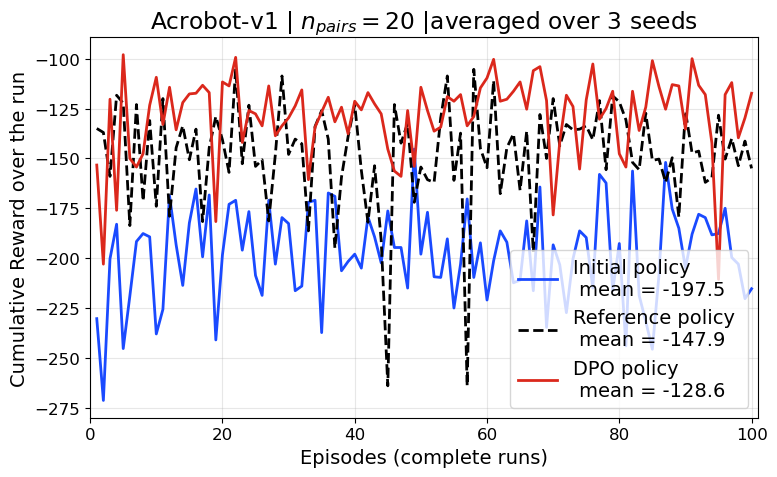

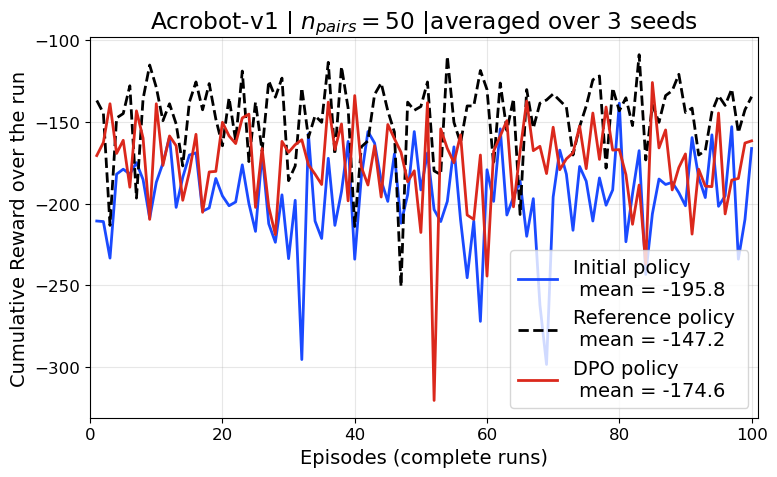

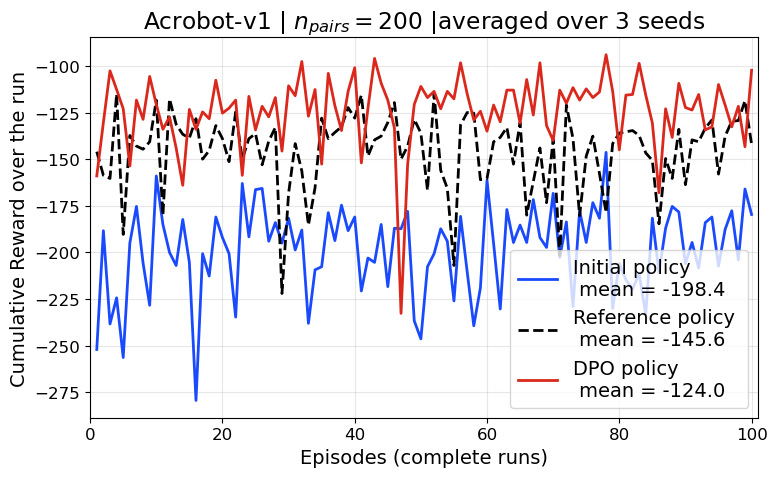

In [9]:

print(f"Evaluating DPO for all seeds and dataset size over {n_eval} Runs \n")
compare_policies     = True
plot_scores          = True
env_name            = "Acrobot-v1" # quick rename

for i, n_pair in enumerate(pair_list):
    print(f"=============== using {n_pair=} ==================")    
    R_ref = 0
    R_init = 0
    R_DPO = 0
    
    for seed, (pi_1, pi_2), pi_DPO in zip(seeds_list, Policy_list, Policy_DPO_list[i]):
        seed_eval = seed+32
        _, pi1_rewards          = evaluate_policy(pi_1,     env, n_episodes=n_eval, seed=seed_eval)
        _, pi2_rewards          = evaluate_policy(pi_2,     env, n_episodes=n_eval, seed=seed_eval)
        _, pi_DPO_rewards  = evaluate_policy(pi_DPO, env, n_episodes=n_eval, seed=seed_eval)
        # _, pi_rlhf_rewards      = evaluate_policy(pi_rlhf,  env, n_episodes=n_eval, seed=seed_eval)

        # print(pi1_rewards, np.mean(pi1_rewards), np.std(pi1_rewards))
        R_ref       += np.array(pi1_rewards)/len(seeds_list)
        R_init      += np.array(pi2_rewards)/len(seeds_list)
        R_DPO  += np.array(pi_DPO_rewards)/len(seeds_list)
        
    if compare_policies:
        print(f"Evaluations over {n_eval} episodes done for the 3 policies, averaged over the 3 seeds for {n_pair=}")
        print(f"pi_1({n_pair})        \t mean reward: \t {np.mean(R_ref):.2f} ± {np.std(R_ref):.2f}")
        print(f"pi_2({n_pair})        \t mean reward: \t {np.mean(R_init):.2f} ± {np.std(R_init):.2f}")
        # print(f"pi_RLHF({seed})     \t mean reward: \t {np.mean(pi_rlhf_rewards):.2f} ± {np.std(pi_rlhf_rewards):.2f}")
        print(f"pi_DPO({n_pair}) \t mean reward: \t {np.mean(R_DPO):.2f} ± {np.std(R_DPO):.2f}")
    if plot_scores:
        plot_scores_RLHF(R_init, R_ref, R_DPO, algo="DPO", save=True, n_pair=n_pair, env_name=env_name)

        print("------------------------------------------------------")



In [10]:

# for seed, (pi_1, pi_2), pi_dpo in zip(seeds_list, Policy_list, Policy_DPO_list):
#   print(f"Evaluating pi_1, pi_2 and pi_DPO with {seed=}, {beta=} over {n_eval} episodes")
#   # Evaluate the policies
#   seed_eval = seed+32
#   _, pi1_rewards     = evaluate_policy(pi_1,        env, n_episodes=n_eval, seed=seed_eval)
#   _, pi_dpo_rewards   = evaluate_policy(pi_dpo,     env, n_episodes=n_eval, seed=seed_eval)
#   _, pi2_rewards      = evaluate_policy(pi_2,       env, n_episodes=n_eval, seed=seed_eval)
#   print(f"Evaluations over {n_eval} episodes using the evalutation seed {seed_eval}")
#   print(f"pi_1({seed})    \t mean reward: \t {np.mean(pi1_rewards):.2f} ± {np.std(pi1_rewards):.2f}")
#   print(f"pi_INIT({seed}) \t mean reward: \t {np.mean(pi2_rewards):.2f} ± {np.std(pi2_rewards):.2f}")
#   print(f"pi_DPO({seed})  \t mean reward: \t {np.mean(pi_dpo_rewards):.2f} ± {np.std(pi_dpo_rewards):.2f}")

#   plot_scores_RLHF(
#       pi2_rewards,
#       pi1_rewards,
#       pi_dpo_rewards,
#       algo="DPO"
#   )
#   print("-------------------------------------")